In [0]:
import numpy as np
import cv2
import os
import model as embedding
import torch
import pickle

In [0]:
# face detection model paths
protoPath = os.getcwd()+"/deploy.prototxt.txt"
modelPath = os.getcwd()+"/res10_300x300_ssd_iter_140000.caffemodel"
# loading detection model
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
# load embedding model
embedder = embedding.InceptionResnetV1(pretrained='vggface2').eval()
# paths to save pickle files
currentDir = os.getcwd()

In [0]:
!mkdir dataset

In [0]:
!unzip /content/data1.zip -d /content/dataset/

Archive:  /content/data1.zip
   creating: /content/dataset/data1/Meet/
  inflating: /content/dataset/data1/Meet/WIN_20190517_13_10_18_Pro.jpg  
  inflating: /content/dataset/data1/Meet/WIN_20190517_13_10_22_Pro.jpg  
  inflating: /content/dataset/data1/Meet/WIN_20190517_13_10_24_Pro.jpg  
   creating: /content/dataset/data1/Tejas/
  inflating: /content/dataset/data1/Tejas/WIN_20190517_13_09_34_Pro.jpg  
  inflating: /content/dataset/data1/Tejas/WIN_20190517_13_09_43_Pro.jpg  
  inflating: /content/dataset/data1/Tejas/WIN_20190517_13_09_46_Pro.jpg  
   creating: /content/dataset/data1/Pranav/
  inflating: /content/dataset/data1/Pranav/WIN_20190517_13_09_00_Pro.jpg  
  inflating: /content/dataset/data1/Pranav/WIN_20190517_13_09_02_Pro.jpg  
  inflating: /content/dataset/data1/Pranav/WIN_20190517_13_09_04_Pro.jpg  
   creating: /content/dataset/data1/Shefali/
  inflating: /content/dataset/data1/Shefali/WIN_20190517_14_34_27_Pro.jpg  
  inflating: /content/dataset/data1/Shefali/WIN_2019051

In [0]:
# images folder
dataset = os.path.join(currentDir, "dataset/data1")
# paths to save pickle files
!mkdir output
!touch  /content/output/SimpleEmbeddings.pickle

In [0]:
# getting all images paths

imagePaths = []

for person in os.listdir(dataset):
  for img in os.listdir(dataset+"/"+person):
    imagePaths.append(dataset+"/"+person+"/"+img)

In [0]:
print(imagePaths)

['/content/dataset/data1/Farzad/WIN_20190517_13_09_57_Pro.jpg', '/content/dataset/data1/Farzad/WIN_20190517_13_10_03_Pro.jpg', '/content/dataset/data1/Farzad/WIN_20190517_13_10_00_Pro.jpg', '/content/dataset/data1/Pranav/WIN_20190517_13_09_04_Pro.jpg', '/content/dataset/data1/Pranav/WIN_20190517_13_09_00_Pro.jpg', '/content/dataset/data1/Pranav/WIN_20190517_13_09_02_Pro.jpg', '/content/dataset/data1/Meet/WIN_20190517_13_10_18_Pro.jpg', '/content/dataset/data1/Meet/WIN_20190517_13_10_24_Pro.jpg', '/content/dataset/data1/Meet/WIN_20190517_13_10_22_Pro.jpg', '/content/dataset/data1/Shefali/WIN_20190517_14_34_27_Pro.jpg', '/content/dataset/data1/Shefali/WIN_20190517_14_34_30_Pro.jpg', '/content/dataset/data1/Shefali/WIN_20190517_14_34_33_Pro.jpg', '/content/dataset/data1/Devansh/WIN_20190517_13_08_51_Pro.jpg', '/content/dataset/data1/Devansh/WIN_20190517_13_08_53_Pro.jpg', '/content/dataset/data1/Devansh/WIN_20190517_13_08_48_Pro.jpg', '/content/dataset/data1/Tejas/WIN_20190517_13_09_43_Pr

In [0]:
# create lists to append ImgPaths/names/imageIDs/boxs/embeddings
ImgPaths = []
names = []
imageIDs = []
boxs = []
embeddings = []

In [0]:
# initlize the total number of faces processed
total = 0

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
  
    print(i,imagePath)
    
    #extract the person name from the image path
    
    name = imagePath.split(os.path.sep)[-2]
    imageID = imagePath.split(os.path.sep)[-1].split('.')[-2]
    
    image = cv2.imread(imagePath)
    (h,w) = image.shape[:2]
    
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    detector.setInput(blob)
    detections = detector.forward()
    
    if len(detections) > 0:
        
        # we're making the assumption that each image has only ONE
        # face, so find the bounding box with the largest probalility
        
        i = np.argmax(detections[0, 0, :, 2])
        confidence = detections[0, 0, i, 2]
        
        # ensure that the detection with the largest probability also
        # means our minimum probability test (thus helping filter out
        # weak detections)
        
        if confidence > 0.5:
            
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            
            (startX, startY, endX, endY) = box.astype("int")
            
            face = image[startY:endY , startX:endX]
            (fH , fW) = face.shape[:2]
            
            
            # ensure the facce width and height are sufficently large
            if fW < 20 or fH < 20:
                continue
                
            try:
                faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,(160, 160), (0, 0, 0), swapRB=True, crop=False)
            except:
                print("[Error] - Face size in Image not sufficent to get Embeddings : ", imagePath)
                continue
            
            faceTensor = torch.tensor(faceBlob)
            faceEmbed = embedder(faceTensor)
            flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
            
            ImgPaths.append(imagePath)
            imageIDs.append(imageID)
            names.append(name)
            boxs.append(box)
            embeddings.append(flattenEmbed)
            total += 1

0 /content/dataset/data1/Farzad/WIN_20190517_13_09_57_Pro.jpg
1 /content/dataset/data1/Farzad/WIN_20190517_13_10_03_Pro.jpg
2 /content/dataset/data1/Farzad/WIN_20190517_13_10_00_Pro.jpg
3 /content/dataset/data1/Pranav/WIN_20190517_13_09_04_Pro.jpg
4 /content/dataset/data1/Pranav/WIN_20190517_13_09_00_Pro.jpg
5 /content/dataset/data1/Pranav/WIN_20190517_13_09_02_Pro.jpg
6 /content/dataset/data1/Meet/WIN_20190517_13_10_18_Pro.jpg
7 /content/dataset/data1/Meet/WIN_20190517_13_10_24_Pro.jpg
8 /content/dataset/data1/Meet/WIN_20190517_13_10_22_Pro.jpg
9 /content/dataset/data1/Shefali/WIN_20190517_14_34_27_Pro.jpg
10 /content/dataset/data1/Shefali/WIN_20190517_14_34_30_Pro.jpg
11 /content/dataset/data1/Shefali/WIN_20190517_14_34_33_Pro.jpg
12 /content/dataset/data1/Devansh/WIN_20190517_13_08_51_Pro.jpg
13 /content/dataset/data1/Devansh/WIN_20190517_13_08_53_Pro.jpg
14 /content/dataset/data1/Devansh/WIN_20190517_13_08_48_Pro.jpg
15 /content/dataset/data1/Tejas/WIN_20190517_13_09_43_Pro.jpg
16 

In [0]:
# paths to embedding pickle file
embeddingPickle = "./output/SimpleEmbeddings.pickle"

# dump the facial embeddings + names to disk
print("[INFO] serializing {} encodings ....".format(total))
data = {"paths":ImgPaths, "names":names, "imageIDs":imageIDs, "boxs":boxs, "embeddings":embeddings}
with open(embeddingPickle , "wb") as f:
  pickle.dump(data,f)

[INFO] serializing 18 encodings ....


In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
import pickle
import numpy as np


# path to recognizer pickle file
!touch /content/output/SimpleRecognizer.pickle
recognizerPickle = "./output/SimpleRecognizer.pickle"

# path to labels pickle file
!touch /content/output/SimpleLabel.pickle
labelPickle = "./output/SimpleLabel.pickle"

# loading embeddings pickle
data = pickle.loads(open(embeddingPickle, "rb").read())

# encode the labels
label = LabelEncoder()
labels = label.fit_transform(data["names"])

# getting embeddings
Embeddings = np.array(data["embeddings"])

# train the model used to accept the 512-d embeddings of the face and 
# then produce the actual face recognition

recognizer = KNeighborsClassifier(n_neighbors= 2, metric='euclidean', weights="distance")
#recognizer = SVC(probability=True)
recognizer.fit(Embeddings, labels)

# write the actual face recognition model to disk
f = open(recognizerPickle, "wb")
f.write(pickle.dumps(recognizer))
f.close()

# write the label encoder to disk
f = open(labelPickle,"wb")
f.write(pickle.dumps(label))
f.close()

In [0]:
# loading face detection model
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# load embedding model
embedder = embedding.InceptionResnetV1(pretrained="vggface2").eval()

# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open(recognizerPickle, "rb").read())
label = pickle.loads(open(labelPickle, "rb").read())

In [0]:
imagePath = os.getcwd() + "/test2.jpg"

predictedImg = os.getcwd()

image = cv2.imread(imagePath)
(h,w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

detector.setInput(blob)
detections = detector.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
    
    # extract the confidence (i.e., probalility) associated with the prediction
    confidence = detections[0, 0, i, 2]
    
    # fillter out weak detections
    if confidence > 0.2:
        
        # compute the (x ,y) - coordinates of the bounding box for the face
        
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        
        # extract the face ROI
        face = image[startY:endY , startX:endX]
        (fH ,fW) = face.shape[:2]
        
        # ensure the facce width and height are sufficently large
        if fW < 20 or fH < 20:
            print("[Error] - Face size in Image not sufficent to get Embeddings : ", imagePath)
            continue
        

        try:
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,(160, 160), (0, 0, 0), swapRB=True, crop=False)
        except:
            print("[Error] - Face size in Image not sufficent to get Embeddings : ", imagePath)
            continue
        
        faceTensor = torch.tensor(faceBlob)
        faceEmbed = embedder(faceTensor)
        flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
        
        array = np.array(flattenEmbed).reshape(1,-1)
        
        # perform classification to recognize the face
        
        preds = recognizer.predict_proba(array)[0]
        
        j = np.argmax(preds)
        
        proba = preds[j]
        name = label.classes_[j]
        
        #draw the bunding box of the face along with the associated probability
        
        text = "{}: {:.2f}%".format(name, proba * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
        
        cv2.putText(image, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.50, (255, 255, 255), 1)
        
# save image predicte folder
cv2.imwrite("pred/{}/test_prediction.png".format(predictedImg), image)

True

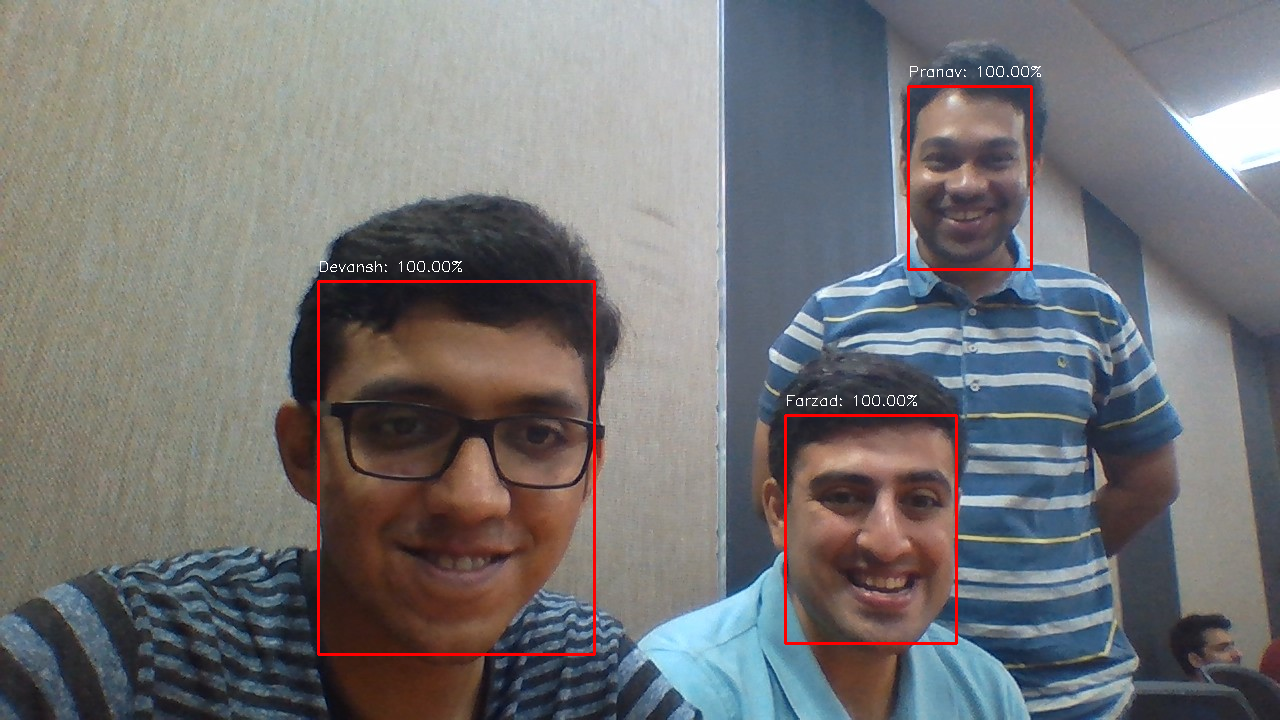

In [12]:
from PIL import Image
i = Image.open(path+'/test_prediction.png')
i

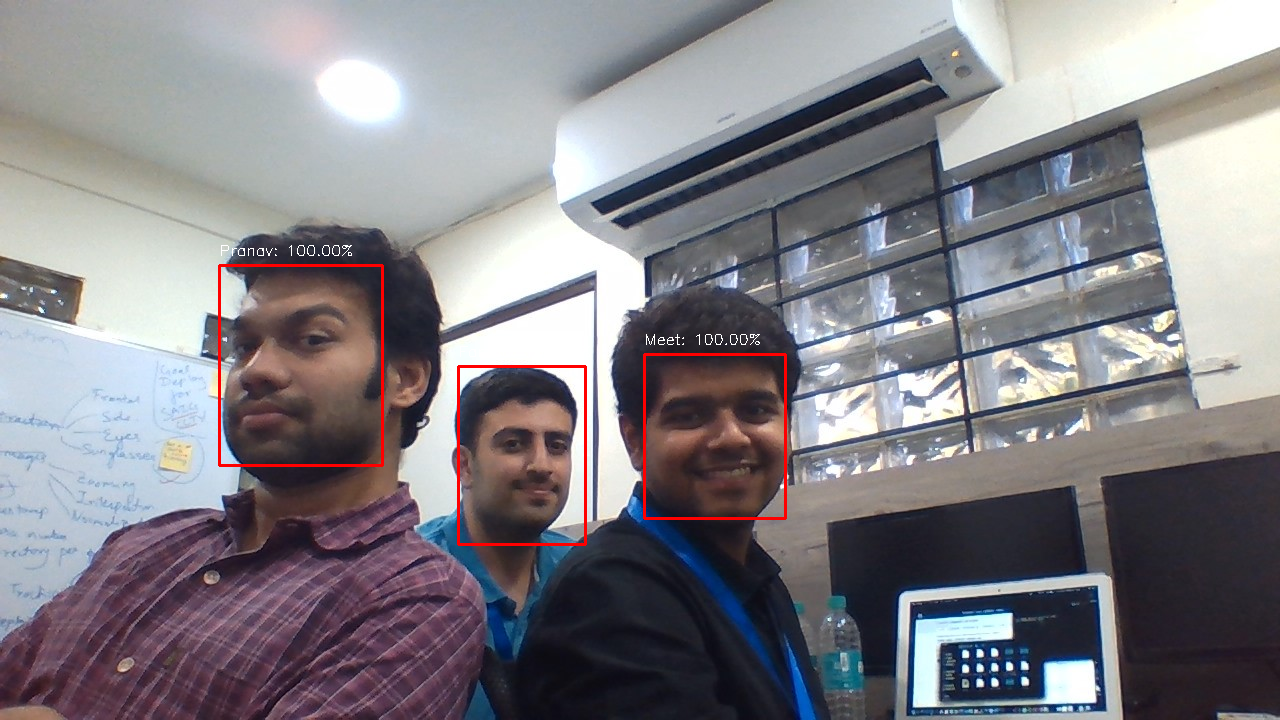

In [13]:
from PIL import Image
i = Image.open(path+'/test_prediction (1).png')
i

In [0]:
import cv2
import os
import matplotlib.pyplot as pp
%matplotlib inline

for dir in os.listdir('pred/'):
  for img in os.listdir('pred/'+dir):
    i = cv2.imread('pred/'+dir+img)
    pp.show(i)